Скачивание всех зависимостей проекта

In [7]:
!pip install -r requirements.txt

Авторизация в wandb 

In [14]:
!wandb login | cat wandb_secret.txt

"cat" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
import keras 

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pymorphy2
import Levenshtein
import gensim.downloader
import wandb
import json
import pickle
from os import path

import warnings
warnings.filterwarnings("ignore")

c:\Users\pasin\DS\Доп\paronyms_with_docker\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Чтение данных

In [3]:
# конфигурация
with open('config.json', 'r') as file:
    config = json.load(file)

cat = config['catboost']
nn = config['nn']
data_path = config['data_path']
inference_path = config["bins_directory"]

In [4]:
# датафрейм 
data = pd.read_csv(data_path, index_col=0)

Препроцессинг

In [5]:
# installing model
word2vec_rus = gensim.downloader.load('word2vec-ruscorpora-300')
word2vec_rus.save(path.join(inference_path, "word2vec_rus.model"))

In [6]:
morph = pymorphy2.MorphAnalyzer()

In [7]:
# get a part of speech needed to make an embedding of word
def get_part_of_speech(word):
    
    parsed_word = morph.parse(word)[0]
    pos = parsed_word.tag.POS

    if pos == "ADJF":
        return "ADJ"
    
    return pos 

In [8]:
# making embedding by pretrained word2vec model 
def get_embedding(word):

    w2v_word = f"{word}_{get_part_of_speech(word)}"

    try:
        emb = word2vec_rus[w2v_word]

    except KeyError:
        return None
    
    return emb

In [9]:
# add extra columns for embeddings 
for i in range(600):
    data[f"emb_{int(i > 299) + 1}_{i % 300}"] = 0
# add extra columns for Levenshtein distance
data["lev_dist"] = 0

rows_to_drop = []

# add embeddings to dataframe 
for i in range(len(data)):

    # get embs for two words
    word1 = data.word1[i]
    word2 = data.word2[i]
    emb1 = get_embedding(word1)
    emb2 = get_embedding(word2)

    if emb1 is not None and emb2 is not None:
        # add embeddings
        data.loc[i, "emb_1_0":"emb_1_299"] = emb1
        data.loc[i, "emb_2_0":"emb_2_299"] = emb2
        data.loc[i, "lev_dist"] = Levenshtein.distance(word1, word2)
        # print("YES", data.word1[i], data.word2[i])

    else: 
        # delete words that are not in word2vec vocabulary
        rows_to_drop.append(i)
        # print("NO", data.word1[i], data.word2[i])

data = data.drop(rows_to_drop, axis=0).reset_index(drop=True)
data.head()

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,2
1,сравнимый,неорганичный,0,-0.043983,-0.009047,-0.063538,0.147805,-0.161587,0.027221,0.032012,...,-0.034892,0.018441,0.069707,-0.001893,-0.062972,0.145138,0.147791,-0.062155,0.080968,7
2,чубастый,завоевательный,0,-0.051917,0.044872,0.014789,0.002823,-0.002203,0.050730,0.031053,...,0.046212,-0.020866,-0.080959,-0.085725,-0.003354,0.015747,0.017519,-0.042495,0.167213,11
3,обидчивый,азарт,0,0.023674,0.052748,-0.034327,-0.031669,-0.014316,0.073295,-0.061295,...,-0.039973,-0.012380,-0.012538,-0.200660,-0.089638,-0.017675,0.042906,-0.012042,-0.019632,9
4,личностный,личный,1,-0.045874,-0.051794,-0.059747,0.019997,-0.075421,-0.042737,-0.057829,...,0.022120,-0.057636,0.027975,-0.042808,-0.101067,0.031723,0.043072,-0.031811,0.032527,4


PCA сокращение размерности эмбедингов

In [10]:
# fitting PCA
def fit_pca(X, n):
    pca = PCA(n_components=n)
    pca.fit(X)
    with open(path.join(inference_path, 'pca_model.pkl'), 'wb') as file:
        pickle.dump(pca, file)
    return pca

# transform dataset to n_componets dimansion
def reduce_dimension(pca, X):
    X_transformed = pca.transform(X)
    return X_transformed

In [11]:
X = data.drop(["word1", "word2", "label"], axis=1)
y = data["label"]

pca_n_components = config["pca_n_components"]

# fit PCA
pca = fit_pca(pd.concat([X.loc[:, "emb_1_0":"emb_1_299"], X.loc[:, "emb_2_0":"emb_2_299"].rename(columns={f"emb_2_{i}":f"emb_1_{i}" for i in range(300)}) ], ignore_index=True), pca_n_components)

# reduce dimensuon with PCA
X.loc[:, "emb_1_0":f"emb_1_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_1_0":"emb_1_299"])
X.loc[:, f"emb_2_0":f"emb_2_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_2_0":"emb_2_299"].rename(columns={f"emb_2_{i}":f"emb_1_{i}" for i in range(300)}))

# drop extra columns of embedding
X = X.drop(list(X.columns[pca_n_components:300]) + list(X.columns[300+pca_n_components:-1]), axis=1)
X.head()

,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,emb_1_7,emb_1_8,emb_1_9,...,emb_2_141,emb_2_142,emb_2_143,emb_2_144,emb_2_145,emb_2_146,emb_2_147,emb_2_148,emb_2_149,lev_dist
0,0.092990,0.064130,-0.009231,-0.117480,0.119546,-0.012407,0.001260,0.036710,0.056213,0.036371,...,0.062502,-0.060111,0.061077,-0.003673,0.017939,0.104934,-0.037184,0.037799,0.073102,2
1,-0.073190,0.121473,0.159301,-0.092435,-0.064993,0.211331,0.043879,-0.079576,0.139455,-0.007544,...,-0.080699,0.038269,-0.053351,-0.064770,0.000613,-0.013418,0.055897,0.011222,0.004277,7
2,0.404789,-0.048654,-0.008222,-0.030356,-0.002151,0.115744,-0.036571,0.107032,-0.181174,-0.009334,...,0.015651,0.011679,0.006728,0.088119,-0.052642,-0.002619,-0.008800,-0.005273,-0.010055,11
3,0.093875,-0.295198,-0.023503,0.178027,-0.329819,-0.137434,0.063096,-0.033621,-0.093355,-0.018621,...,-0.041227,-0.025539,-0.024182,-0.075806,-0.063785,0.054486,-0.002228,0.006784,-0.010276,9
4,-0.438857,-0.025888,0.076917,-0.048277,-0.095658,-0.114352,-0.050336,-0.016784,0.099319,-0.067100,...,0.005611,-0.013451,-0.006786,0.031827,-0.006357,0.033231,-0.045223,-0.014141,0.015577,4


In [12]:
# PCA explained variance 
np.sum(pca.explained_variance_ratio_)

0.81573728602066

Feature ingineering 

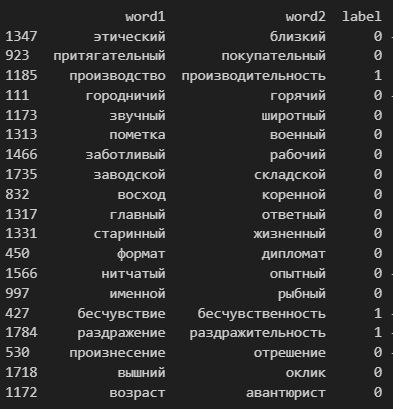

На одном из прогонов модели после вывода слов, в которых модель ошиблась, я заметил что модель часто допускает ошибку первого рода (ложноположительные объекты). Хотя по словам, в которых модель ошиблась, легко понять что они не паронимы, тк между ними большое расстояние Левенштейна. Возможно, модель не обращает достаточного внимания на слова с большим расстоянием Левенштейна, поэтому введем два новых признака

 - квадрат расстояния Левенштейна
 - процент добавленных символов (расстояние Левенштейна, деленое на максимальную длину слова)

In [13]:
X["lev_dist_2"] = X.lev_dist**2
X["lev_dist_%"] = 0
for i in range(len(data.word1)):
    X["lev_dist_%"][i] = X.lev_dist[i] / max(len(data.word1[i]), len(data.word2[i]))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Катбуст

In [15]:
if config["logging"]:
    wandb.init(project="paronyms", tags=["cat", "with dist 2", "with dist %"])

In [21]:
with open('best_params.json', 'r') as file:
    best_params = json.load(file)

# # uncomment to train with optuna
# def objective(trial):
#     params = {
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
#         'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0)
#     }

#     model = CatBoostClassifier(verbose=0, **params)
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
#     mae = mean_absolute_error(y_test, predictions)

#     return mae

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=cat["n_trials"])
# best_params = study.best_params

cat_model = CatBoostClassifier(verbose=0, **best_params)
cat_model.fit(X_train, y_train)
best_predictions = cat_model.predict(X_test)
best_mae = mean_absolute_error(y_test, best_predictions)
predictions = cat_model.predict_proba(X_test)

print('Best Parameters:', best_params)

Best Parameters: {'learning_rate': 0.011289064280955217, 'depth': 7, 'l2_leaf_reg': 0.5808384667318421, 'bagging_temperature': 0.09136846123232852}


In [17]:
treshold = cat["treshold"]

mae = mean_absolute_error(y_test, predictions[:, 1])
acc = accuracy_score(y_test, [1 if prob > treshold else 0 for prob in predictions[:, 1]])
print('MAE:', mae, ' Accuracy:', acc)

if config["logging"]:
    wandb.log({'MAE': mae, 'Accuracy': acc, "params": best_params.update({"pca_comp": config["pca_n_components"]})})
    wandb.finish()

MAE: 0.0380153410378956  Accuracy: 0.970108695652174


In [34]:
cat_model.save_model(path.join(inference_path, 'catboost_model.bin'))

In [18]:
# слова в которых модель ошиблась
errors = y_test != [1 if prob > treshold else 0 for prob in predictions[:, 1]]
words_with_errors = data.iloc[errors[errors==True].index]
print(words_with_errors[["word1", "word2", "label"]])

               word1           word2  label
1347       этический         близкий      0
923   притягательный   покупательный      0
111       городничий         горячий      0
548        иноверный  единоверческий      0
1466      заботливый         рабочий      0
1735       заводской       складской      0
1331       старинный       жизненный      0
694     почтительный    добровольный      0
940   реалистический     токсический      0
367        житейский       жизненный      1
530     произнесение       отрешение      0


In [19]:
# get feature importance
feature_importances = cat_model.feature_importances_

for i, importance in enumerate(feature_importances):
    print(f"{X.columns[i]}: {importance}")

emb_1_0: 0.5492088621338842
emb_1_1: 0.2901040384694448
emb_1_2: 0.221159883917448
emb_1_3: 0.13076684801310345
emb_1_4: 0.6618053901286243
emb_1_5: 0.22492131870535043
emb_1_6: 0.07456481811021771
emb_1_7: 0.22423435902203276
emb_1_8: 0.13968074330643385
emb_1_9: 0.2151243247357989
emb_1_10: 0.19876659500104485
emb_1_11: 0.10145437847276267
emb_1_12: 0.09499204525861032
emb_1_13: 1.3889088755086543
emb_1_14: 0.13397580129055375
emb_1_15: 0.09490906410067207
emb_1_16: 0.29492303618705434
emb_1_17: 0.06723149344450408
emb_1_18: 0.056746529363205324
emb_1_19: 0.1230002267987576
emb_1_20: 0.135209521424885
emb_1_21: 0.30742914831971974
emb_1_22: 0.1639769455799822
emb_1_23: 0.12113830399533801
emb_1_24: 0.11533585050718936
emb_1_25: 0.06559902982283704
emb_1_26: 0.3609286265308446
emb_1_27: 0.21661732877136033
emb_1_28: 0.20618494612253283
emb_1_29: 0.10752002350801809
emb_1_30: 0.21978662413374495
emb_1_31: 0.1991811701811608
emb_1_32: 0.15382196457214445
emb_1_33: 0.08637439914472317
em

Text(0.5, 1.0, 'feature importance of embedding columns')

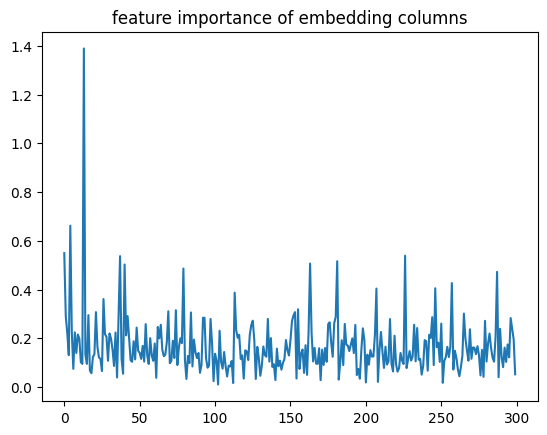

In [76]:
# plotting feature importance of embeddings
plt.plot(cat_model.feature_importances_[:-3])
plt.title('feature importance of embedding columns')

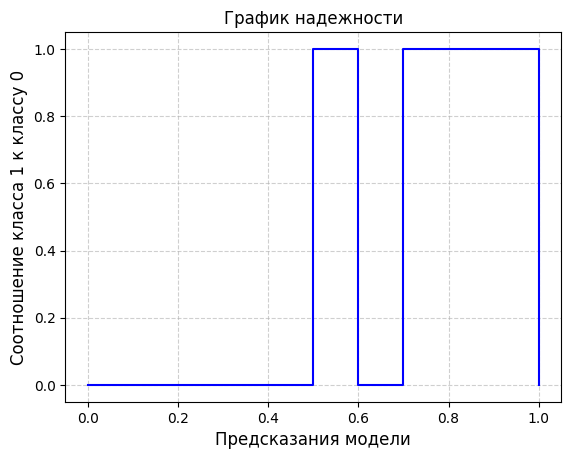

In [75]:
x_values = []
y_values = []

step = 0.1
x_cur = 0
while x_cur < 1:
    count = sum(1 for x in predictions[:, 1] if x_cur <= x <= x_cur+step)
    first_label = sum(1 for x in predictions[:, 1] if x_cur <= x <= x_cur+step and x > treshold)
    y = 0 if count==0 else first_label / count
    x_values.append(x_cur)
    y_values.append(y)
    x_cur += step

plt.step(x_values, y_values, where='post', color='blue', linestyle='-', linewidth=1.5)
plt.xlabel('Предсказания модели', fontsize=12)
plt.ylabel('Соотношение класса 1 к классу 0', fontsize=12)
plt.title('График надежности')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

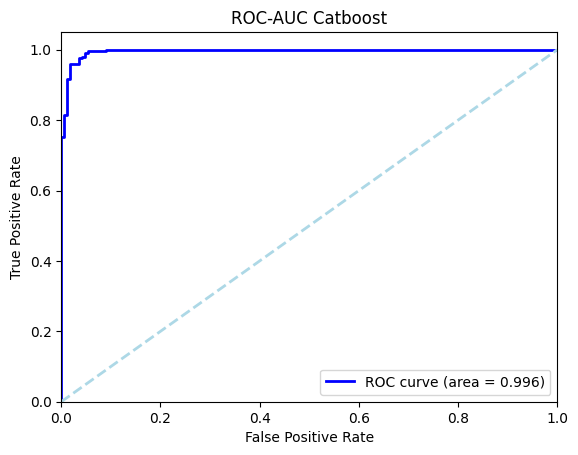

In [73]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predictions[:, 1])

# Расчет площади под ROC-кривой (AUC)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure()
lw = 2  # Ширина линии
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot(fpr, tpr, color='navy', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot(fpr, tpr, color='blue', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) # Голубой цвет
plt.plot([0, 1], [0, 1], color='lightblue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show()

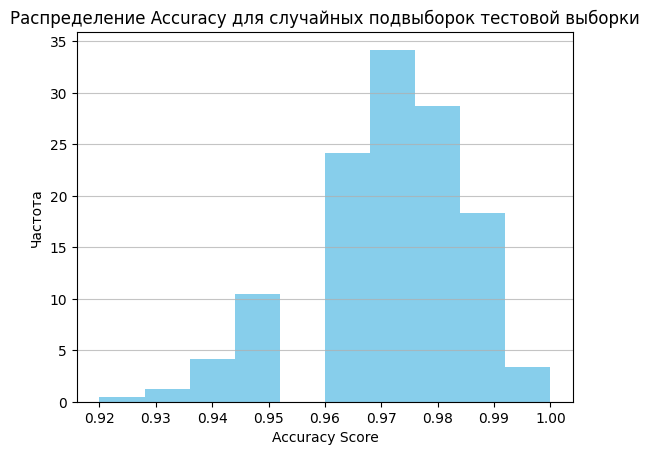

5-й квантиль: 0.95
95-й квантиль: 0.99


In [77]:
accuracy_scores = []

for _ in range(300):
    sample_indices = rng.choice(X_test.index, size=100, replace=False)
    X_test_sample = X_test.loc[sample_indices]
    y_test_sample = y_test.loc[sample_indices]

    y_pred_sample = cat_model.predict(X_test_sample)

    accuracy = accuracy_score(y_test_sample, y_pred_sample)
    accuracy_scores.append(accuracy)

plt.hist(accuracy_scores, bins=10, density=True, color='skyblue')
plt.title('Распределение Accuracy для случайных подвыборок тестовой выборки')
plt.xlabel('Accuracy Score')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Вычисление 5-го и 95-го квантилей
quantile_5 = np.percentile(accuracy_scores, 5)
quantile_95 = np.percentile(accuracy_scores, 95)

print(f"5-й квантиль: {quantile_5}")
print(f"95-й квантиль: {quantile_95}")

Нейросеть

In [95]:
# Логирование
if config["logging"]:
    wandb.init(project="paronyms", tags=["nn", "with dist 2", "with dist %"])
    wandb.log(nn)

batch_size,▁
epochs,▁
lr,▁
pca_comp,▁
treshold,▁
batch_size,8
epochs,500
lr,0.05
optim,adagrad
pca_comp,150
treshold,0.5


In [96]:
nn_model = tf.keras.Sequential()

optimizer = keras.optimizers.Adam(learning_rate=nn["lr"])
# optimizer = keras.optimizers.Adagrad(learning_rate=nn["lr"], initial_accumulator_value=0.1) 
layers = nn["layers"]
activations = nn["activations"]

for i in range(len(layers)):
    if i == 0:
        nn_model.add(tf.keras.layers.Dense(layers[i], activation=activations[i], input_shape=(X_train.shape[1],)))
    else:
        nn_model.add(tf.keras.layers.Dense(layers[i], activation=activations[i]))

nn_model.compile(optimizer=optimizer, loss='mean_absolute_error')

history = nn_model.fit(X_train, y_train, epochs=nn["epochs"], batch_size=nn["batch_size"], verbose=0)

predictions = nn_model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


MAE: 0.05934618377739962  Accuracy: 0.9402173913043478


Accuracy,▁
MAE,▁
batch_size,▁
epochs,▁
lr,▁
treshold,▁
Accuracy,0.94022
MAE,0.05935
batch_size,8
epochs,100
lr,0.001


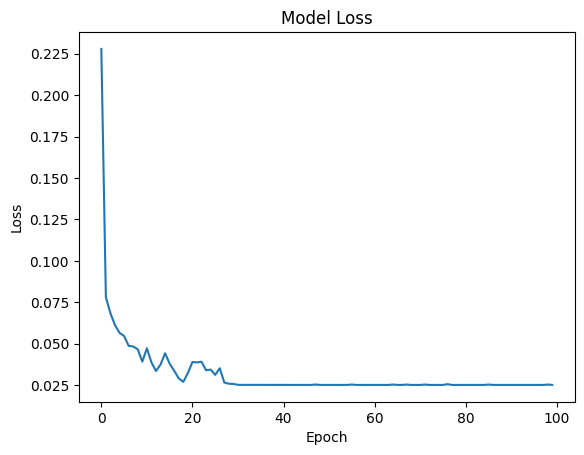

In [97]:
treshold = nn["treshold"]

mae = mean_absolute_error(y_test, predictions)
acc = accuracy_score(y_test, [1 if prob > treshold else 0 for prob in predictions])
print('MAE:', mae, ' Accuracy:', acc)

if config["logging"]:
    wandb.log({'MAE': mae, 'Accuracy': acc, "params": nn.update({"pca_comp": config["pca_n_components"], "optim": "adagrad"})})
    wandb.finish()

# Plotting the loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Тестирование

In [58]:
# function for testing new words
def test(word1, word2, model):

    # getting embs and lev dist 
    emb1, emb2 = get_embedding(word1), get_embedding(word2)
    pca_emb1 = reduce_dimension(pca, emb1.reshape(1, -1))
    pca_emb2 = reduce_dimension(pca, emb2.reshape(1, -1))
    lev_dist = Levenshtein.distance(word1, word2)

    # creating dataframe
    row = pca_emb1.tolist()[0] + pca_emb2.tolist()[0] + [lev_dist]
    X_new = pd.DataFrame([row], columns=X.columns)
    
    # predictions 
    if model == "cat":
        prediction = cat_model.predict_proba(X_new)
        res = np.argmax(prediction[0])
        proba = max(prediction[0])

    if model == "nn":
        prediction = nn_model.predict(X_new)
        if prediction[0][0] < 0.5:
            res = 0
            proba = 1 - (prediction[0][0] if prediction[0][0] > 0 else 0)
        else:
            res = 1
            proba = (prediction[0][0] if prediction[0][0] < 1 else 1)

    # result
    print(f"Слова {word1} и {word2} {'не '*(not res)}являются паронимами с вероятностью {proba}")

In [59]:
# не паронимы
word1 = "приветливый"
word2 = "страна" 

# паронимы
word1 = "целый"
word2 = "цельный" 

# модель 
model = "cat" # nn - keras nn, cat - catboostclassifier

# тестирование
test(word1, word2, model)

Слова целый и цельный являются паронимами с вероятностью 0.9995663900978244


In [ ]:
X.shape

Мусорка

In [ ]:
data

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,аккордовый,квадрат,0,-0.012578,0.071381,-0.066920,0.132629,0.039623,0.068954,-0.102715,...,0.012084,0.054774,0.012667,-0.049291,0.144537,-0.074161,-0.035057,0.081322,0.129544,0
1,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,0
2,женский,господний,0,0.044881,-0.092671,0.050879,-0.044229,0.011045,0.028815,-0.058337,...,0.073815,0.014237,0.103689,0.109344,0.009336,0.047421,0.005184,0.071654,-0.028561,0
3,обличительный,динамизм,0,0.066741,0.038244,0.027620,0.058278,0.048305,0.110592,-0.115581,...,-0.102109,0.129003,-0.052745,-0.043174,-0.039006,0.050456,-0.007910,-0.029959,0.016620,0
4,сыскать,снискать,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,гнилой,гнилостный,1,0.022569,-0.047862,0.049707,0.058395,0.006504,0.046971,0.035626,...,-0.091607,0.088824,0.001456,-0.006952,0.041889,0.050071,0.102235,-0.003491,-0.002087,0
3512,кормильщица,притягательный,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3513,абонемент,абонент,1,0.068919,0.042074,-0.030451,-0.087799,0.016597,-0.016370,0.019723,...,0.067424,0.100960,0.029388,-0.060928,0.016881,-0.025644,-0.061658,-0.017059,-0.043113,0
3514,беженец,выучить,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [ ]:
get_embedding(data['word1'][0])

array([-1.25777004e-02,  7.13808015e-02, -6.69195578e-02,  1.32629201e-01,
        3.96230109e-02,  6.89538270e-02, -1.02715276e-01, -2.07985435e-02,
       -4.17454605e-04, -6.66920096e-02,  1.85652584e-01, -1.44832075e-01,
        2.83512380e-02, -1.11901104e-01,  4.56056818e-02, -4.81510274e-02,
        8.36276039e-02, -9.19803232e-03,  9.81500838e-04,  5.74996658e-02,
       -2.92572589e-03,  6.52177706e-02, -4.75657806e-02,  4.61040102e-02,
       -3.82861830e-02,  5.70593216e-02, -3.37926932e-02,  1.21076353e-01,
       -1.81092322e-02,  9.62400343e-03, -1.48299234e-02,  1.01952113e-01,
        1.60059571e-01, -5.47798118e-03,  3.87733914e-02,  3.83970179e-02,
        1.25514701e-01, -8.64881873e-02,  2.29348727e-02, -2.13215649e-02,
       -1.91617105e-02, -1.42319629e-03, -1.11882702e-01, -8.07544217e-02,
       -5.52563854e-02,  1.29661132e-02, -3.10040861e-02, -4.55451086e-02,
        4.72736470e-02, -7.49781057e-02, -9.20100696e-03,  5.29071130e-02,
        6.45692181e-03,  

In [ ]:
morph = pymorphy2.MorphAnalyzer()

word = 'знамя_NOUN'
parsed_word = morph.parse(word)[0]
pos = parsed_word.tag.POS

print(pos)

None
